In [ ]:
## Connect to gg driver
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AI Tutor/CV/Topic1: Introduce DL and CV/day02

/content/drive/.shortcut-targets-by-id/1g_hBCGxmI5lTFXyvD-igJcroxCjDzObt/AI Tutor/CV/Topic1: Introduce DL and CV/day02


## 1. EDA bộ dataset

- Hiển thị được phân phối class của tập train/test
- Thông kê được tổng số dữ liệu, tổng số class

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch.optim as optim
from glob import glob
from tqdm import tqdm
import random
from torch.utils.data import DataLoader

In [ ]:
# Chuẩn bị transform
# Chuẩn bị transform
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Tải dữ liệu
train_data = torchvision.datasets.ImageFolder(root='dataset/train', transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(root='dataset/test', transform=test_transforms)
# Số lượng các lớp
num_classes = len(train_data.classes)
# Tên của các lớp
classes_name = train_data.classes
# classes2idx: ánh xạ từ tên lớp sang chỉ số (index)
classes2idx = train_data.class_to_idx
print(f"Số lượng lớp: {num_classes}")
print(f"Tên lớp: {classes_name}")
print(f"Ánh xạ từ tên lớp sang chỉ số: {classes2idx}")
print("Number of train: ", len(train_data))
print("Number of test: ", len(test_data))


Số lượng lớp: 6
Tên lớp: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Ánh xạ từ tên lớp sang chỉ số: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of train:  14034
Number of test:  3115


In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

run: 100%|██████████| 6/6 [00:00<00:00, 24.58it/s]


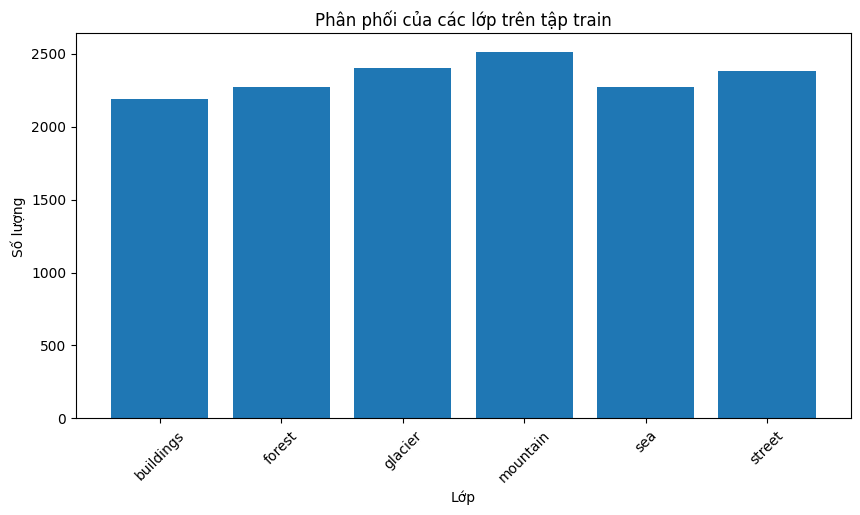

In [ ]:
# Phân phối của các lớp trên tập train
all_class = glob("dataset/train/*")
train_class_counts =  {}
for folder_class in tqdm(all_class, desc='run'):
    name = folder_class.split('/')[-1]
    train_class_counts[name] = len(glob(f"{folder_class}/*"))
train_class_counts = dict(sorted(train_class_counts.items(), key=lambda item: item[0]))

plt.figure(figsize=(10, 5))
plt.bar(list(train_class_counts.keys()), list(train_class_counts.values()))
plt.title('Phân phối của các lớp trên tập train')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

run: 100%|██████████| 6/6 [00:00<00:00, 126.60it/s]


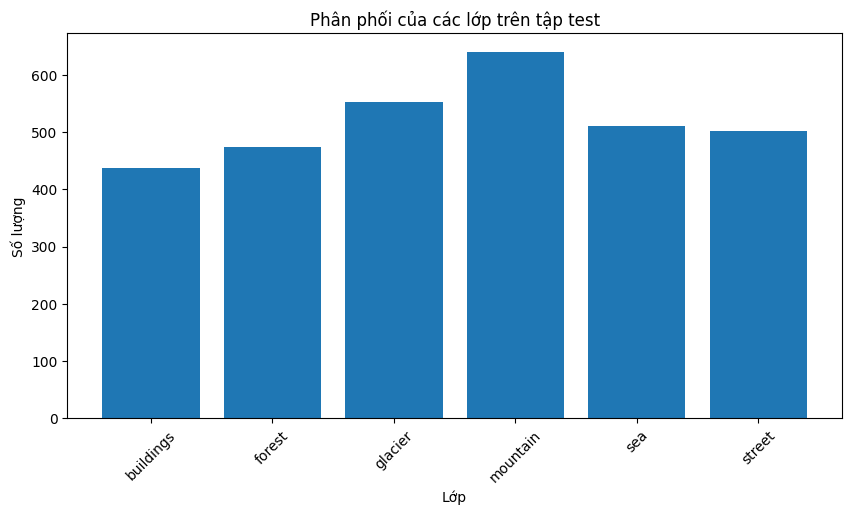

In [ ]:
# Phân phối của các lớp trên tập test
all_test_classes = glob("dataset/test/*")
test_class_counts = {}
for folder_class in tqdm(all_test_classes, desc='run'):
    name = folder_class.split('/')[-1]
    test_class_counts[name] = len(glob(f"{folder_class}/*"))

# Sort dict by key
test_class_counts = dict(sorted(test_class_counts.items(), key=lambda item: item[0]))

# Hiển thị đồ thị phân phối tập test
plt.figure(figsize=(10, 5))
plt.bar(list(test_class_counts.keys()), list(test_class_counts.values()))
plt.title('Phân phối của các lớp trên tập test')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Khởi tạo kích thước của figure
num_rows = len(classes_name)
num_cols = 3
plt.figure(figsize=(num_cols * 4, num_rows * 4))

# Vòng lặp để vẽ hình
for idx, c in enumerate(classes_name, start=1):
    # Lấy ngẫu nhiên một hình từ thư mục train và test
    path_test_image = random.choice(list(glob(f"dataset/test/{c}/*")))
    path_train_image = random.choice(list(glob(f"dataset/train/{c}/*")))

    # Thêm subplot cho cặp hình
    plt.subplot(num_rows, num_cols, idx * num_cols - 2)
    plt.imshow(plt.imread(path_train_image))
    plt.title(f"Train - {c}")
    plt.axis("off")

    plt.subplot(num_rows, num_cols, idx * num_cols - 1)
    plt.imshow(plt.imread(path_test_image))
    plt.title(f"Test - {c}")
    plt.axis("off")

# Hiển thị đồ thị
plt.tight_layout()
plt.show()




Output hidden; open in https://colab.research.google.com to view.

## 2. Modeling

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

#### Define models CNNs basic

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer 1
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer 2
        self.fc1 = nn.Linear(32*62*62, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
## Kiểm tra tính hoạt động của mạng custom này
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 256, 256)
model(random_image).shape

torch.Size([1, 10])

In [ ]:
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 448, 448)
model(random_image).shape

RuntimeError: ignored

### => Error do việc fix cứng 32x62x62

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer 1
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer 2
        self.avgpool = nn.AdaptiveAvgPool2d((16, 16))
        self.fc1 = nn.Linear(32*16*16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
## Kiểm tra tính hoạt động của mạng custom này
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 256, 256)
model(random_image).shape

torch.Size([1, 10])

In [ ]:
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 448, 448)
model(random_image).shape

torch.Size([1, 10])

## => Ý nghĩa thực sự của hàm AdaptiveAvgPool2d

In [ ]:
## Kiêm tra số parameters


## 3. Training model

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
BATCH_SIZE = 64  # You can adjust this based on your needs
# Create data loaders
TRAINLOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
DEVICE

device(type='cuda')

In [ ]:
# Init Model
model = SimpleCNN(num_classes=num_classes)
model.to(DEVICE)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = optim.SGD(model.parameters(), lr=0.001)# Choose the optimizer
scheduler = CosineAnnealingLR(optimizer, T_max=5)  # Choose the scheduler


In [ ]:
loss_train = []
loss_test = []
f1_train = []
f1_test = []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    predictions_train = []
    true_labels_train = []
    for i, data in tqdm(enumerate(TRAINLOADER), desc='train'):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs =  model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predictions_train.extend(predicted.tolist())
        true_labels_train.extend(labels.tolist())
    if scheduler is not None:
        scheduler.step()  # Update learning rate with scheduler
    train_loss = running_loss / len(TRAINLOADER)
    train_f1 = f1_score(true_labels_train, predictions_train, average='weighted')

    loss_train.append(train_loss)
    f1_train.append(train_f1)

    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_loss_val = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in TESTLOADER:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            #outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    test_loss_val /= len(TESTLOADER)
    test_f1_val = f1_score(true_labels, predictions, average='weighted')

    loss_test.append(test_loss_val)
    f1_test.append(test_f1_val)
    print(f'Epoch [{epoch + 1}/{EPOCHS}]  - Train Loss: {train_loss:.4f} - Train F1: {train_f1:.4f} - Test Loss: {test_loss_val:.4f} - Test F1: {test_f1_val:.4f}')

print('Finished Training')

train: 220it [24:26,  6.67s/it]


Epoch [1/50]  - Train Loss: 1.7462 - Train F1: 0.2260 - Test Loss: 1.7063 - Test F1: 0.2251


train: 220it [01:03,  3.47it/s]


Epoch [2/50]  - Train Loss: 1.6513 - Train F1: 0.2539 - Test Loss: 1.5995 - Test F1: 0.3071


train: 220it [01:03,  3.45it/s]


Epoch [3/50]  - Train Loss: 1.5462 - Train F1: 0.3394 - Test Loss: 1.5085 - Test F1: 0.3485


train: 220it [01:02,  3.51it/s]


Epoch [4/50]  - Train Loss: 1.4770 - Train F1: 0.3804 - Test Loss: 1.4616 - Test F1: 0.3804


train: 220it [01:03,  3.46it/s]


Epoch [5/50]  - Train Loss: 1.4473 - Train F1: 0.3981 - Test Loss: 1.4500 - Test F1: 0.3857


train: 220it [01:02,  3.53it/s]


Epoch [6/50]  - Train Loss: 1.4417 - Train F1: 0.4008 - Test Loss: 1.4500 - Test F1: 0.3857


train: 220it [01:03,  3.49it/s]


Epoch [7/50]  - Train Loss: 1.4354 - Train F1: 0.4030 - Test Loss: 1.4390 - Test F1: 0.3970


train: 220it [01:03,  3.48it/s]


Epoch [8/50]  - Train Loss: 1.4098 - Train F1: 0.4177 - Test Loss: 1.4002 - Test F1: 0.4085


train: 220it [01:03,  3.49it/s]


Epoch [9/50]  - Train Loss: 1.3626 - Train F1: 0.4381 - Test Loss: 1.3452 - Test F1: 0.4371


train: 220it [01:03,  3.49it/s]


Epoch [10/50]  - Train Loss: 1.3039 - Train F1: 0.4668 - Test Loss: 1.2919 - Test F1: 0.4721


train: 220it [01:03,  3.49it/s]


Epoch [11/50]  - Train Loss: 1.2491 - Train F1: 0.4955 - Test Loss: 1.2381 - Test F1: 0.5138


train: 220it [01:02,  3.50it/s]


Epoch [12/50]  - Train Loss: 1.2040 - Train F1: 0.5192 - Test Loss: 1.1987 - Test F1: 0.5152


train: 220it [01:03,  3.47it/s]


Epoch [13/50]  - Train Loss: 1.1702 - Train F1: 0.5348 - Test Loss: 1.1742 - Test F1: 0.5289


train: 220it [01:03,  3.48it/s]


Epoch [14/50]  - Train Loss: 1.1490 - Train F1: 0.5430 - Test Loss: 1.1577 - Test F1: 0.5349


train: 220it [01:02,  3.52it/s]


Epoch [15/50]  - Train Loss: 1.1402 - Train F1: 0.5494 - Test Loss: 1.1530 - Test F1: 0.5384


train: 220it [01:03,  3.46it/s]


Epoch [16/50]  - Train Loss: 1.1388 - Train F1: 0.5494 - Test Loss: 1.1530 - Test F1: 0.5384


train: 220it [01:02,  3.52it/s]


Epoch [17/50]  - Train Loss: 1.1383 - Train F1: 0.5500 - Test Loss: 1.1495 - Test F1: 0.5416


train: 220it [01:02,  3.49it/s]


Epoch [18/50]  - Train Loss: 1.1306 - Train F1: 0.5527 - Test Loss: 1.1370 - Test F1: 0.5486


train: 220it [01:03,  3.48it/s]


Epoch [19/50]  - Train Loss: 1.1149 - Train F1: 0.5600 - Test Loss: 1.1170 - Test F1: 0.5625


train: 220it [01:03,  3.49it/s]


Epoch [20/50]  - Train Loss: 1.0897 - Train F1: 0.5691 - Test Loss: 1.0932 - Test F1: 0.5565


train: 220it [01:03,  3.46it/s]


Epoch [21/50]  - Train Loss: 1.0665 - Train F1: 0.5778 - Test Loss: 1.0707 - Test F1: 0.5702


train: 220it [01:02,  3.51it/s]


Epoch [22/50]  - Train Loss: 1.0454 - Train F1: 0.5869 - Test Loss: 1.0508 - Test F1: 0.5757


train: 220it [01:02,  3.50it/s]


Epoch [23/50]  - Train Loss: 1.0302 - Train F1: 0.5939 - Test Loss: 1.0385 - Test F1: 0.5849


train: 220it [01:03,  3.47it/s]


Epoch [24/50]  - Train Loss: 1.0192 - Train F1: 0.5968 - Test Loss: 1.0329 - Test F1: 0.5863


train: 220it [01:03,  3.49it/s]


Epoch [25/50]  - Train Loss: 1.0140 - Train F1: 0.5981 - Test Loss: 1.0298 - Test F1: 0.5879


train: 220it [01:02,  3.53it/s]


Epoch [26/50]  - Train Loss: 1.0133 - Train F1: 0.5968 - Test Loss: 1.0298 - Test F1: 0.5879


train: 220it [01:03,  3.44it/s]


Epoch [27/50]  - Train Loss: 1.0124 - Train F1: 0.5982 - Test Loss: 1.0296 - Test F1: 0.5883


train: 220it [01:03,  3.49it/s]


Epoch [28/50]  - Train Loss: 1.0097 - Train F1: 0.6009 - Test Loss: 1.0233 - Test F1: 0.5869


train: 220it [01:03,  3.46it/s]


Epoch [29/50]  - Train Loss: 1.0031 - Train F1: 0.6037 - Test Loss: 1.0142 - Test F1: 0.6037


train: 220it [01:02,  3.50it/s]


Epoch [30/50]  - Train Loss: 0.9927 - Train F1: 0.6099 - Test Loss: 1.0038 - Test F1: 0.5868


train: 220it [01:02,  3.55it/s]


Epoch [31/50]  - Train Loss: 0.9806 - Train F1: 0.6124 - Test Loss: 0.9911 - Test F1: 0.6160


train: 220it [01:03,  3.48it/s]


Epoch [32/50]  - Train Loss: 0.9694 - Train F1: 0.6227 - Test Loss: 0.9860 - Test F1: 0.6189


train: 220it [01:01,  3.55it/s]


Epoch [33/50]  - Train Loss: 0.9568 - Train F1: 0.6302 - Test Loss: 0.9738 - Test F1: 0.6234


train: 220it [01:02,  3.53it/s]


Epoch [34/50]  - Train Loss: 0.9516 - Train F1: 0.6332 - Test Loss: 0.9687 - Test F1: 0.6156


train: 220it [01:03,  3.44it/s]


Epoch [35/50]  - Train Loss: 0.9461 - Train F1: 0.6331 - Test Loss: 0.9667 - Test F1: 0.6203


train: 220it [01:02,  3.54it/s]


Epoch [36/50]  - Train Loss: 0.9459 - Train F1: 0.6353 - Test Loss: 0.9667 - Test F1: 0.6203


train: 220it [01:02,  3.52it/s]


Epoch [37/50]  - Train Loss: 0.9469 - Train F1: 0.6351 - Test Loss: 0.9647 - Test F1: 0.6165


train: 220it [01:02,  3.53it/s]


Epoch [38/50]  - Train Loss: 0.9443 - Train F1: 0.6330 - Test Loss: 0.9599 - Test F1: 0.6264


train: 220it [01:02,  3.54it/s]


Epoch [39/50]  - Train Loss: 0.9406 - Train F1: 0.6369 - Test Loss: 0.9527 - Test F1: 0.6282


train: 220it [01:03,  3.45it/s]


Epoch [40/50]  - Train Loss: 0.9318 - Train F1: 0.6420 - Test Loss: 0.9451 - Test F1: 0.6268


train: 220it [01:02,  3.53it/s]


Epoch [41/50]  - Train Loss: 0.9252 - Train F1: 0.6470 - Test Loss: 0.9359 - Test F1: 0.6457


train: 220it [01:01,  3.56it/s]


Epoch [42/50]  - Train Loss: 0.9138 - Train F1: 0.6510 - Test Loss: 0.9310 - Test F1: 0.6341


train: 220it [01:03,  3.49it/s]


Epoch [43/50]  - Train Loss: 0.9059 - Train F1: 0.6567 - Test Loss: 0.9219 - Test F1: 0.6437


train: 220it [01:02,  3.54it/s]


Epoch [44/50]  - Train Loss: 0.8980 - Train F1: 0.6610 - Test Loss: 0.9196 - Test F1: 0.6459


train: 220it [01:02,  3.54it/s]


Epoch [45/50]  - Train Loss: 0.8953 - Train F1: 0.6633 - Test Loss: 0.9166 - Test F1: 0.6458


train: 220it [01:02,  3.52it/s]


Epoch [46/50]  - Train Loss: 0.8926 - Train F1: 0.6634 - Test Loss: 0.9166 - Test F1: 0.6458


train: 220it [01:01,  3.58it/s]


Epoch [47/50]  - Train Loss: 0.8923 - Train F1: 0.6649 - Test Loss: 0.9151 - Test F1: 0.6433


train: 220it [01:02,  3.54it/s]


Epoch [48/50]  - Train Loss: 0.8933 - Train F1: 0.6636 - Test Loss: 0.9112 - Test F1: 0.6438


train: 220it [01:01,  3.56it/s]


Epoch [49/50]  - Train Loss: 0.8897 - Train F1: 0.6646 - Test Loss: 0.9096 - Test F1: 0.6583


train: 220it [01:01,  3.56it/s]


Epoch [50/50]  - Train Loss: 0.8843 - Train F1: 0.6678 - Test Loss: 0.9000 - Test F1: 0.6467
Finished Training


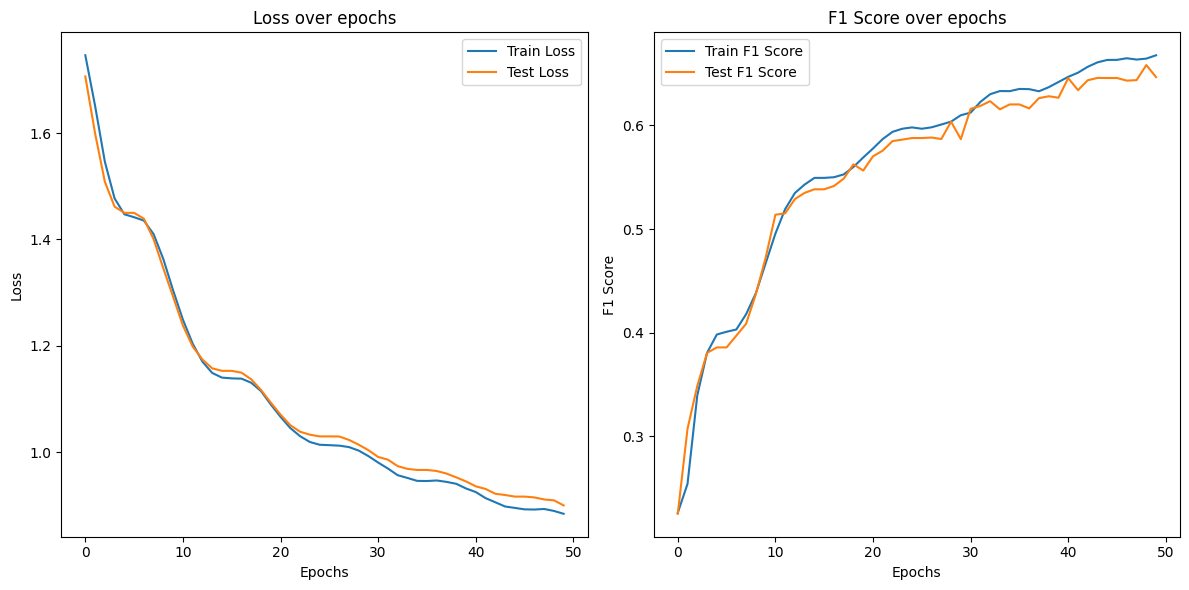

In [ ]:
# Plotting the metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_test, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f1_train, label='Train F1 Score')
plt.plot(f1_test, label='Test F1 Score')
plt.title('F1 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Evaluation Model

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns


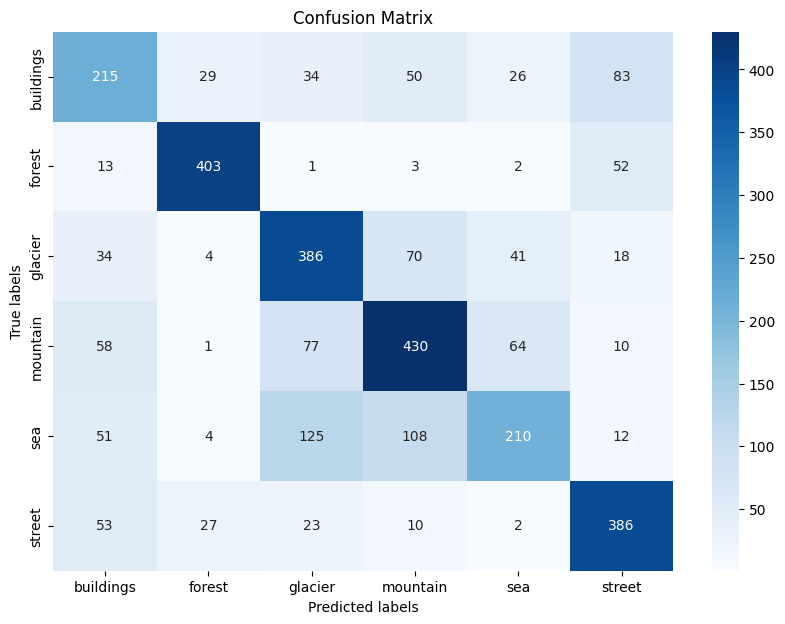

In [ ]:
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for data in TESTLOADER:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().tolist())
        all_true_labels.extend(labels.cpu().tolist())


# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print("Weighted F1 Score:", f1)

Weighted F1 Score: 0.6466849918765705


In [ ]:
print(classification_report(all_true_labels, all_predictions, target_names=classes_name))

              precision    recall  f1-score   support

   buildings       0.51      0.49      0.50       437
      forest       0.86      0.85      0.86       474
     glacier       0.60      0.70      0.64       553
    mountain       0.64      0.67      0.66       640
         sea       0.61      0.41      0.49       510
      street       0.69      0.77      0.73       501

    accuracy                           0.65      3115
   macro avg       0.65      0.65      0.65      3115
weighted avg       0.65      0.65      0.65      3115



## 5. Practices
Hãy thử làm mọi cách để f1_score trên tập test đạt >= 85%
- Thử thay bằng model có độ phức tạp hơn ( Có dropout, Batch_Norm )
- Dùng optimizer khác, scheduler khác
- Thử tăng hoặc giảm Learning rate, Batch_size
- Thử dùng [Lion Optimizer](https://github.com/lucidrains/lion-pytorch)
```python
!pip install lion-pytorch
from lion_pytorch import Lion
opt = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
```



- Question: ý nghĩa của lớp **AdaptiveAvgPool2d**

https://pytorch.org/docs/stable/nn.html